## This notebook supports word-level interaction explanations rather than token-level explanations

In [ ]:
import torch
from transformers import *
import numpy as np
import sys

sys.path.append("../../src")
from explainer import Archipelago
from application_utils.text_utils import *
from application_utils.text_utils_torch import BertWrapperTorch
from viz.text import viz_text

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Get Model

In [ ]:
device = torch.device("cuda:0")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model_path = "../../downloads/pretrained_bert"
model = BertForSequenceClassification.from_pretrained(model_path)
model_wrapper = BertWrapperTorch(model, device)

## Define Text

In [3]:
text = "It's solid and affecting and exactly as thought-provoking as it should be"

baseline_token = "_"

## Get Sentiment

In [4]:
text_ids, baseline_ids = get_input_baseline_ids(text, baseline_token, tokenizer)

class_idx = 1
logit = model_wrapper([text_ids])[0,class_idx].item()
polarity = "positive" if logit > 0 else "negative"
print(polarity, logit)

positive 4.273921012878418


## Explain Prediction

In [5]:
class WordXformer(TextXformer):
    # A minor change to TextXformer to perturb groups of token ids rather than individual token ids
    def __init__(self, input_grouped_ids, baseline_grouped_ids):
        TextXformer.__init__(self, input_grouped_ids, baseline_grouped_ids)

    def __call__(self, inst):
        perturbed_words_as_token_id_groups = self.efficient_xform(inst)
        flattened_token_ids = []
        for id_group in perturbed_words_as_token_id_groups:
            flattened_token_ids.extend(id_group)
        return flattened_token_ids
    
def get_token_id_groups_from_words_in_input(text, baseline_token, tokenizer):
    # get default start and end ids of a sentence
    text_ids, baseline_ids = get_input_baseline_ids(text, baseline_token, tokenizer)
    start_id, end_id = text_ids[0], text_ids[-1]

    # get each word in the input text as a list of corresponding token ids
    orig_token_id_groups = [tokenizer.encode(word, add_special_tokens=False) for word in text.split()]
    assert [j for i in orig_token_id_groups for j in i] == text_ids[1:-1].tolist()
    
    # add the start and end ids to the original token_id_groups
    token_id_groups = [[start_id]] + list(orig_token_id_groups) + [[end_id]]
    
    # create corresponding token ids groups for the baseline as well
    baseline_id_groups = [[start_id]] + [[baseline_ids[1]]*len(grp) for grp in token_id_groups[1:-1]] + [[end_id]]
    return token_id_groups, baseline_id_groups

In [6]:
token_id_groups, baseline_id_groups = get_token_id_groups_from_words_in_input(text, baseline_token, tokenizer)

xf = WordXformer(token_id_groups, baseline_id_groups) 
apgo = Archipelago(model_wrapper, data_xformer=xf, output_indices=class_idx, batch_size=20)

In [7]:
explanation = apgo.explain(top_k=3)

### Show Explanation

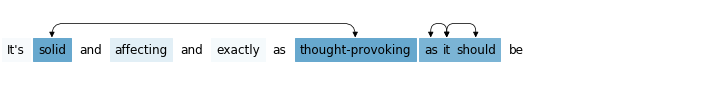

In [8]:
tokens = ['CLS'] + text.split() + ['SEP']
explanation, tokens = process_stop_words(explanation, tokens)
fig = viz_text(explanation, tokens)